# Histopathologic Cancer Detection

- This is my second notebook, i tried to use traditional CNN model to classify the images. But the result is not promising
- The problem or the challenge here is that we need use CNN to classify canser images
- First of all we need to import necessary libraries


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
base_dir = '/kaggle/input/histopathologic-cancer-detection/'
print(os.listdir(base_dir))

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

['sample_submission.csv', 'test', 'train', 'train_labels.csv']


# Data Exploration 
- **ID Column**: Each `id` corresponds to an image file in the dataset, serving as a unique identifier for the histopathologic scan.
- **Label Column**: Binary labels indicate the target variable for our predictive modeling task, where `1` represents the presence of cancerous tissue, and `0` signifies its absence.

In [ ]:
full_train_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
train_labels['label'].value_counts()

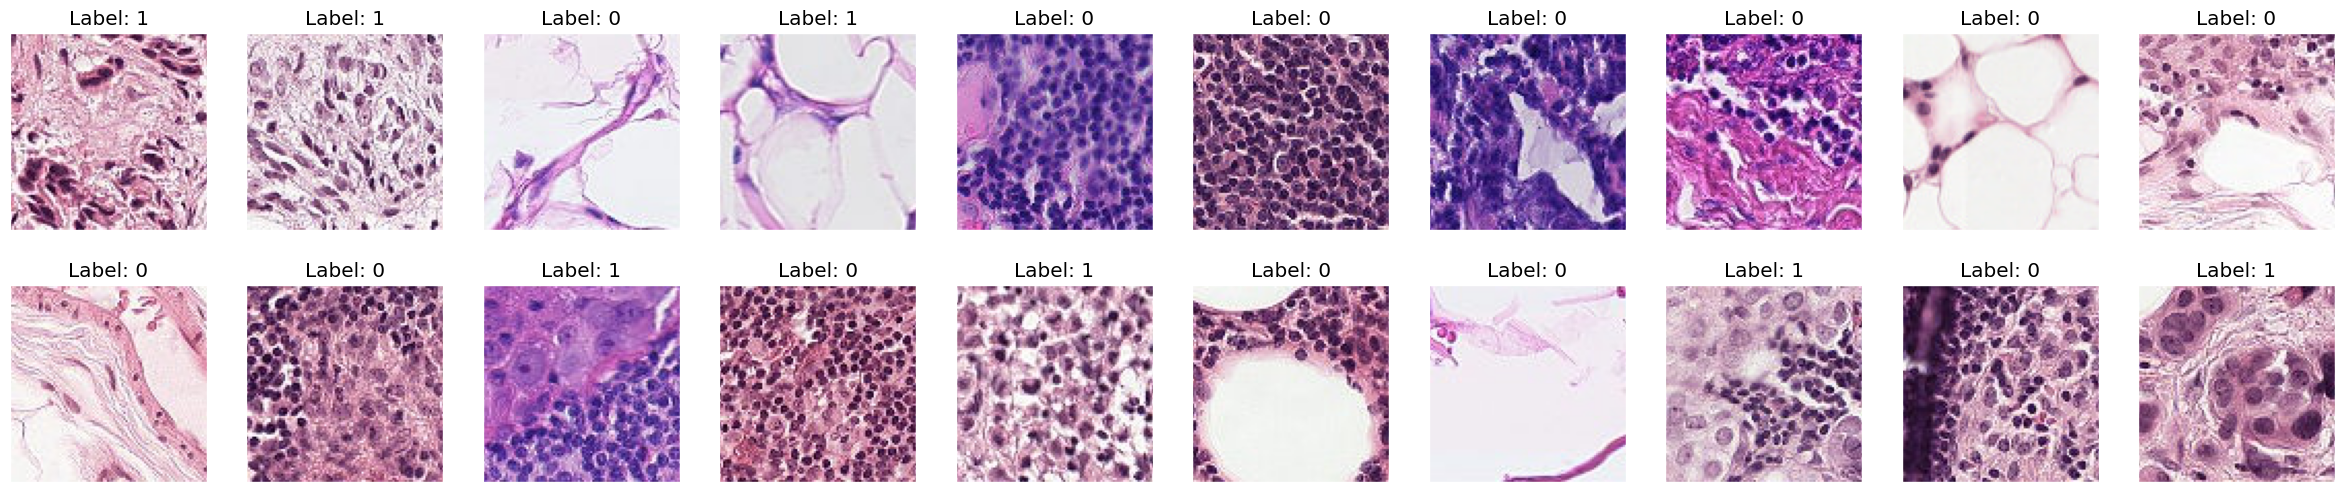

In [ ]:

fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

## Balancing the Dataset for Model Training

### Strategy for Balancing:

#### Process:
- To address potential class imbalance and ensure a fair representation of both classes in our model training process, we balanced the dataset by selecting equal numbers of positive (`label` = 1) and negative (`label` = 0) samples.
- Specifically, we chose 80,000 samples from each class, utilizing random sampling to maintain diversity and representativeness within the subsets.

### Data Preparation Steps:

1. **Sample Selection**:
   - Separately sampled 80,000 negative examples (where `label` = 0) and 80,000 positive examples (where `label` = 1) from the full training dataset, ensuring an equal representation of both classes.
   
2. **Concatenation and Shuffling**:
   - Concatenated the positive and negative samples into a single DataFrame and then shuffled the combined dataset. This step is crucial to prevent any order bias during model training and ensure that the model is exposed to a balanced mix of samples across training epochs.

3. **Resulting Dataset**:
   - The balanced training dataset now consists of 160,000 samples, evenly divided between positive and negative classes. This balance is instrumental in training a model that can accurately identify cancerous tissue without bias toward the more prevalent class.

### Importance of Dataset Balance:

- **Model Performance**: A balanced dataset helps prevent the model from developing a bias toward the majority class, a common issue in imbalanced datasets that can significantly affect performance metrics.
- **Generalization Ability**: By ensuring an equal representation of both classes, the model is better equipped to generalize its learning to unseen data, improving its reliability and utility in real-world applications.

In [ ]:
# Number of samples in each class
SAMPLE_SIZE = 80000

# Data paths
train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

# Use 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(160000, 2)

## Custom Dataset Class for Histopathologic Cancer Detection

### Key Components of the `CreateDataset` Class:

- **Initialization (`__init__`)**:
  - `df_data`: A DataFrame containing the image IDs and their corresponding labels. This DataFrame is converted to a numpy array for efficient data retrieval.
  - `data_dir`: The directory path where the image files are stored. It defaults to the current directory but can be set to the specific location of the histopathologic scan images.
  - `transform`: Optional transformations (e.g., resizing, normalization) to be applied to the images. This allows for easy integration of data augmentation and preprocessing steps.

- **Length (`__len__`)**:
  - Returns the total number of images in the dataset, allowing PyTorch's data loader to iterate over the dataset correctly.

- **Get Item (`__getitem__`)**:
  - Retrieves an image by its index, applies the specified transformations, and returns the image and its label. This method makes the dataset compatible with PyTorch's batch loading and processing.

In [ ]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

## Setting Up Data Loaders for Training and Validation

### Data Loader Configuration:

In the preparation phase for training our CNN model, we configure the data loaders that will supply the training and validation datasets to the model during the training process. This setup is crucial for efficient and effective model training.

### Steps Involved:

1. **Batch Size Selection**:
   - A batch size of 128 is chosen for training. This size is a balance between computational efficiency and the ability to generalize across training examples.

2. **Validation Set Split**:
   - We allocate 10% of the training set for validation purposes (`valid_size = 0.1`). This split allows us to evaluate the model's performance on unseen data, ensuring that we maintain a robust measure of its generalization capability.

3. **Indexing and Sampling**:
   - The training dataset indices are shuffled and split according to the specified validation size. This random shuffling ensures that both the training and validation sets are representative of the overall dataset distribution.
   - `SubsetRandomSampler` is utilized to sample elements randomly from a given list of indices, providing an effective mechanism for creating training and validation datasets without the need for duplicating data.

4. **Data Loaders Creation**:
   - PyTorch's `DataLoader` class is used to create the data loaders for both the training and validation sets, incorporating the samplers to fetch data in batches from the subsets defined by our samplers.
   - This approach efficiently manages memory usage and enhances computational performance by leveraging batch processing during model training and evaluation.

In [ ]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
sample_sub = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Convolutional Neural Network (CNN) Architecture

### Overview of the CNN Model:

The CNN model designed for the Histopathologic Cancer Detection challenge is structured to efficiently process image data and perform binary classification to determine the presence of cancer in histopathologic scans.

### Architecture Details:

- **Convolutional Layers**:
  - The model features a series of five convolutional layers, each followed by batch normalization, a ReLU activation function, and max pooling.
  - The convolutional layers progressively increase the number of channels from 32 to 512, allowing the model to capture a wide range of features from the input images.

- **Dropout Layers**:
  - Dropout layers are interspersed within the network, specifically after the convolutional blocks, to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.

- **Fully Connected Layers**:
  - After the convolutional layers, the model transitions to three fully connected layers, decreasing in size from 1024 to 512 to 1, the final output size.
  - A sigmoid activation function is used at the output to provide a probability indicating the presence of cancer.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

        self.dropout2d = nn.Dropout2d()


        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())

    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape) <-- Life saving debugging step :D
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [ ]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

## Model Training, Validation, and Early Stopping

### Training Process Overview:

The training loop is designed to optimize the model over `20` epochs, with each epoch consisting of a training phase followed by a validation phase. This approach allows for continuous monitoring and evaluation of the model's performance.

### Training Phase:

- **Model State**: The model is set to training mode (`model.train()`), enabling certain layers like dropout and batch normalization to behave accordingly.
- **Batch Processing**: For each batch in the training dataset, the data and labels are loaded, optionally moved to a GPU for accelerated computation, and then passed through the model.
- **Loss Calculation and Backpropagation**: The loss is computed using the model's output and the actual labels, followed by backpropagation through the model's parameters to update the weights using gradient descent.

### Validation Phase:

- **Model Evaluation Mode**: The model is set to evaluation mode (`model.eval()`), which disables dropout and batch normalization layers for consistent performance metrics.
- **Loss and AUC Calculation**: As with training, the loss for each batch is calculated. Additionally, the Area Under the ROC Curve (AUC) is computed to provide insight into the model's discriminative ability between the classes.
- **AUC Aggregation**: The AUC scores for all validation batches are aggregated to give a single performance metric for each epoch.

In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))

    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.206484 | Validation Loss: 0.222226 | Validation AUC: 0.9738
Validation loss decreased (inf --> 0.222226).  Saving model ...
Epoch: 2 | Training Loss: 0.195881 | Validation Loss: 0.219962 | Validation AUC: 0.9750
Validation loss decreased (0.222226 --> 0.219962).  Saving model ...
Epoch: 3 | Training Loss: 0.186183 | Validation Loss: 0.197511 | Validation AUC: 0.9759
Validation loss decreased (0.219962 --> 0.197511).  Saving model ...
Epoch: 4 | Training Loss: 0.179325 | Validation Loss: 0.174500 | Validation AUC: 0.9773
Validation loss decreased (0.197511 --> 0.174500).  Saving model ...
Epoch: 5 | Training Loss: 0.173372 | Validation Loss: 0.168577 | Validation AUC: 0.9783
Validation loss decreased (0.174500 --> 0.168577).  Saving model ...
Epoch: 6 | Training Loss: 0.166736 | Validation Loss: 0.242542 | Validation AUC: 0.9786
Epoch: 7 | Training Loss: 0.161597 | Validation Loss: 0.142679 | Validation AUC: 0.9799
Validation loss decreased (0.168577 --> 0.14

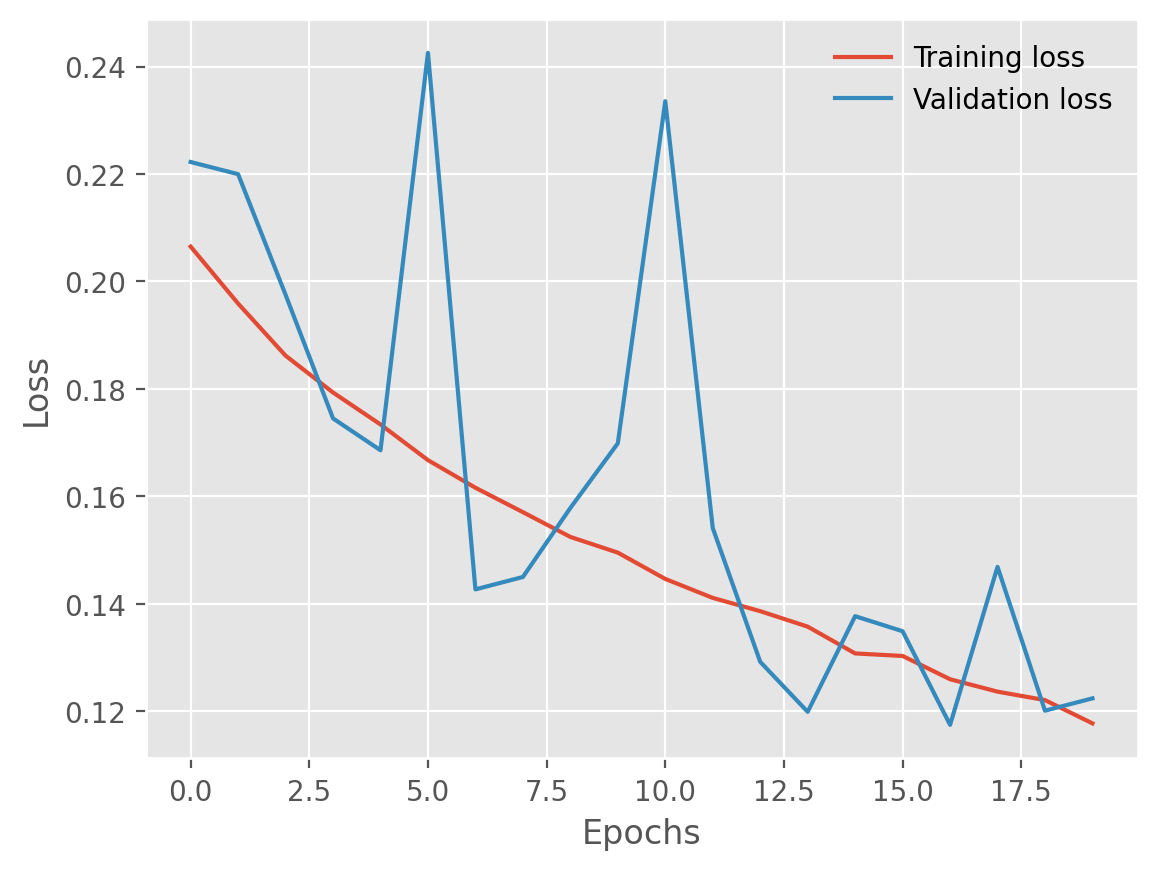

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

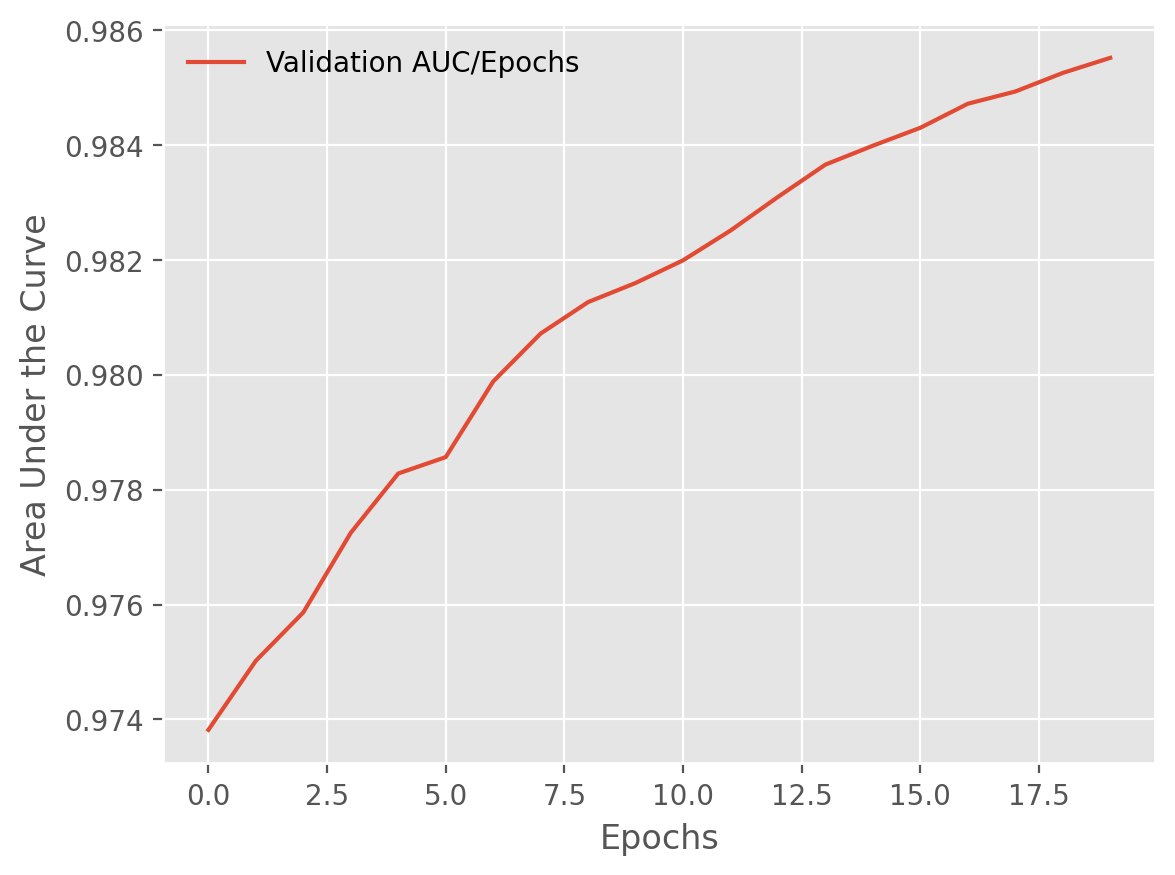

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [ ]:
# Turn off gradients
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file
sample_sub['label'] = preds

In [ ]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float64(sample_sub.label[i])

<ipython-input-26-59b574d62378>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_sub.label[i] = np.float64(sample_sub.label[i])


In [ ]:
sample_sub.to_csv('submission7.csv', index=False)
sample_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.015973
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.285953
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000342
3,2c35657e312966e9294eac6841726ff3a748febf,0.001399
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.094344
